In [8]:
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms

from retinanet import model
import pytorch_lightning
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

In [9]:
torch.cuda.is_available()

True

In [10]:
logger = TensorBoardLogger("./runs", name = "retinanet")
retinanet = model.resnet50(80)
retinanet.load_state_dict(torch.load("./coco_resnet_50_map_0_335_state_dict.pt"))

<All keys matched successfully>

In [11]:
retinanet
torch.save(retinanet, "retinanet_pretrained.pt")

Using cache found in C:\Users\Thanh Dat/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-7 Python-3.9.6 torch-1.13.0 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


before .pandas(): image 1/1: 640x640 5 dogs
Speed: 4.0ms pre-process, 304.2ms inference, 3.0ms NMS per image at shape (1, 3, 640, 640)
after .pandas():          xmin        ymin        xmax        ymax  confidence  class name
0  477.420715  271.180542  639.317688  471.458923    0.861052     16  dog
1  240.905075  232.621826  373.678894  430.883606    0.796279     16  dog
2    0.000000  274.285370  197.475891  469.673004    0.757625     16  dog
3  364.230286  299.361267  497.901489  458.780212    0.727345     16  dog
4  160.258575  297.801971  273.081085  436.914398    0.433253     16  dog
after to_dict: {'xmin': {0: 477.42071533203125, 1: 240.9050750732422, 2: 0.0, 3: 364.23028564453125, 4: 160.25857543945312}, 'ymin': {0: 271.1805419921875, 1: 232.621826171875, 2: 274.2853698730469, 3: 299.36126708984375, 4: 297.8019714355469}, 'xmax': {0: 639.3176879882812, 1: 373.67889404296875, 2: 197.47589111328125, 3: 497.9014892578125, 4: 273.0810852050781}, 'ymax': {0: 471.45892333984375, 1: 43

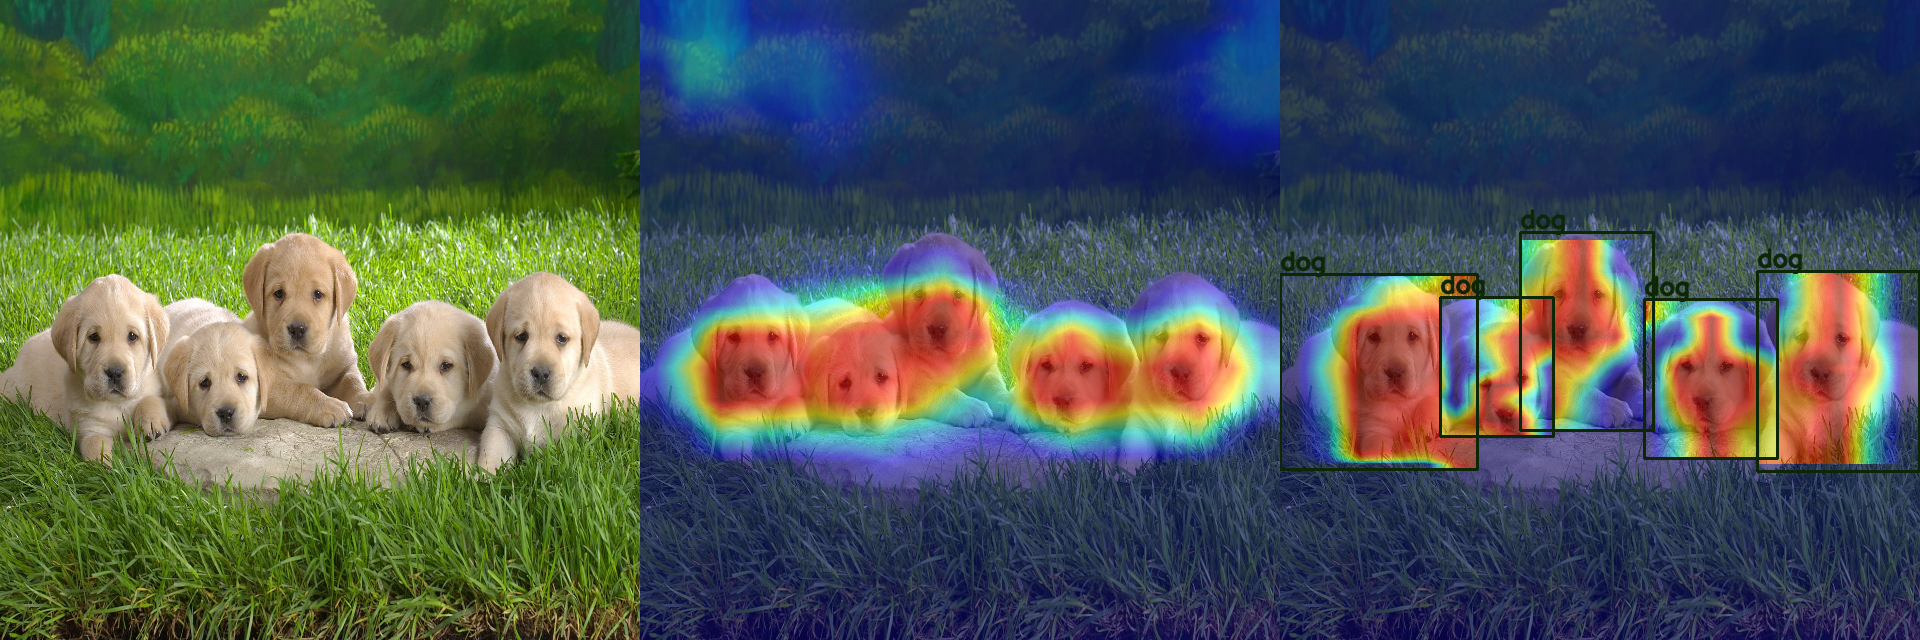

In [34]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    print(f"before .pandas(): {results}")
    detections = results.pandas().xyxy[0]
    print(f"after .pandas(): {detections}")
    detections = detections.to_dict()
    print(f"after to_dict: {detections}")
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


image_url = "https://upload.wikimedia.org/wikipedia/commons/f/f1/Puppies_%284984818141%29.jpg"
img = np.array(Image.open("./data/Puppies_(4984818141).jpg"))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())

cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)

Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))


In [13]:
import pandas as pd

classes = """person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
dining table
toilet
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush"""
class_lst = classes.split("\n")
cat_ids = list(range(len(class_lst)))
df = pd.DataFrame({"class": class_lst, "id": cat_ids})
df.to_csv("class_mapping.csv", header=False, index=False)

In [71]:
import torch
import numpy as np
import time
import os
import csv
import cv2
import argparse


def load_classes(csv_reader):
    result = {}

    for line, row in enumerate(csv_reader):
        line += 1

        try:
            class_name, class_id = row
        except ValueError:
            raise(ValueError('line {}: format should be \'class_name,class_id\''.format(line)))
        class_id = int(class_id)

        if class_name in result:
            raise ValueError('line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
    return result


# Draws a caption above the box in an image
def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 0), 3)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 3, (255, 255, 255), 3)

def detect_image(image_path, model_path, class_list):

    with open(class_list, 'r') as f:
        classes = load_classes(csv.reader(f, delimiter=','))

    labels = {}
    for key, value in classes.items():
        labels[value] = key

    model = torch.load(model_path)

    if torch.cuda.is_available():
        model = model.cuda()

    model.training = False
    model.eval()

    for img_name in os.listdir(image_path):

        image = cv2.imread(os.path.join(image_path, img_name))
        if image is None:
            continue
        image_orig = image.copy()

        rows, cols, cns = image.shape

        smallest_side = min(rows, cols)

        # rescale the image so the smallest side is min_side
        min_side = 608
        max_side = 1024
        scale = min_side / smallest_side

        # check if the largest side is now greater than max_side, which can happen
        # when images have a large aspect ratio
        largest_side = max(rows, cols)

        if largest_side * scale > max_side:
            scale = max_side / largest_side

        # resize the image with the computed scale
        image = cv2.resize(image, (int(round(cols * scale)), int(round((rows * scale)))))
        rows, cols, cns = image.shape

        pad_w = 32 - rows % 32
        pad_h = 32 - cols % 32

        new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
        new_image[:rows, :cols, :] = image.astype(np.float32)
        image = new_image.astype(np.float32)
        image /= 255
        image -= [0.485, 0.456, 0.406]
        image /= [0.229, 0.224, 0.225]
        image = np.expand_dims(image, 0)
        image = np.transpose(image, (0, 3, 1, 2))

        lbs, bboxes = [], []
        with torch.no_grad():

            image = torch.from_numpy(image)
            if torch.cuda.is_available():
                image = image.cuda()

            st = time.time()
            print(image.shape, image_orig.shape, scale)
            scores, classification, transformed_anchors = model(image.cuda().float())
            print('Elapsed time: {}'.format(time.time() - st))
            idxs = np.where(scores.cpu() > 0.5)

            for j in range(idxs[0].shape[0]):
                bbox = transformed_anchors[idxs[0][j], :]

                x1 = int(bbox[0] / scale)
                y1 = int(bbox[1] / scale)
                x2 = int(bbox[2] / scale)
                y2 = int(bbox[3] / scale)
                label_name = labels[int(classification[idxs[0][j]])]
                lbs.append(label_name)
                bboxes.append(bbox)
                print(bbox, classification.shape)
                score = scores[j]
                caption = '{} {:.3f}'.format(label_name, score)
                # draw_caption(img, (x1, y1, x2, y2), label_name)
                draw_caption(image_orig, (x1, y1, x2, y2), caption)
                cv2.rectangle(image_orig, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)

            return image_orig, lbs, bboxes


torch.Size([1, 3, 640, 832]) (1200, 1600, 3) 0.5066666666666667
Elapsed time: 0.3730008602142334
tensor([8.91953e-02, 2.57734e+02, 2.23806e+02, 4.47148e+02], device='cuda:0') torch.Size([48])
tensor([600.50104, 256.44391, 810.36139, 456.98358], device='cuda:0') torch.Size([48])
tensor([262.08713, 218.84015, 462.04251, 414.53571], device='cuda:0') torch.Size([48])
tensor([459.58560, 283.75525, 630.39673, 412.93231], device='cuda:0') torch.Size([48])
tensor([197.49609, 289.12421, 327.83844, 417.17737], device='cuda:0') torch.Size([48])
tensor([207.40466, 260.12164, 395.69250, 415.86853], device='cuda:0') torch.Size([48])


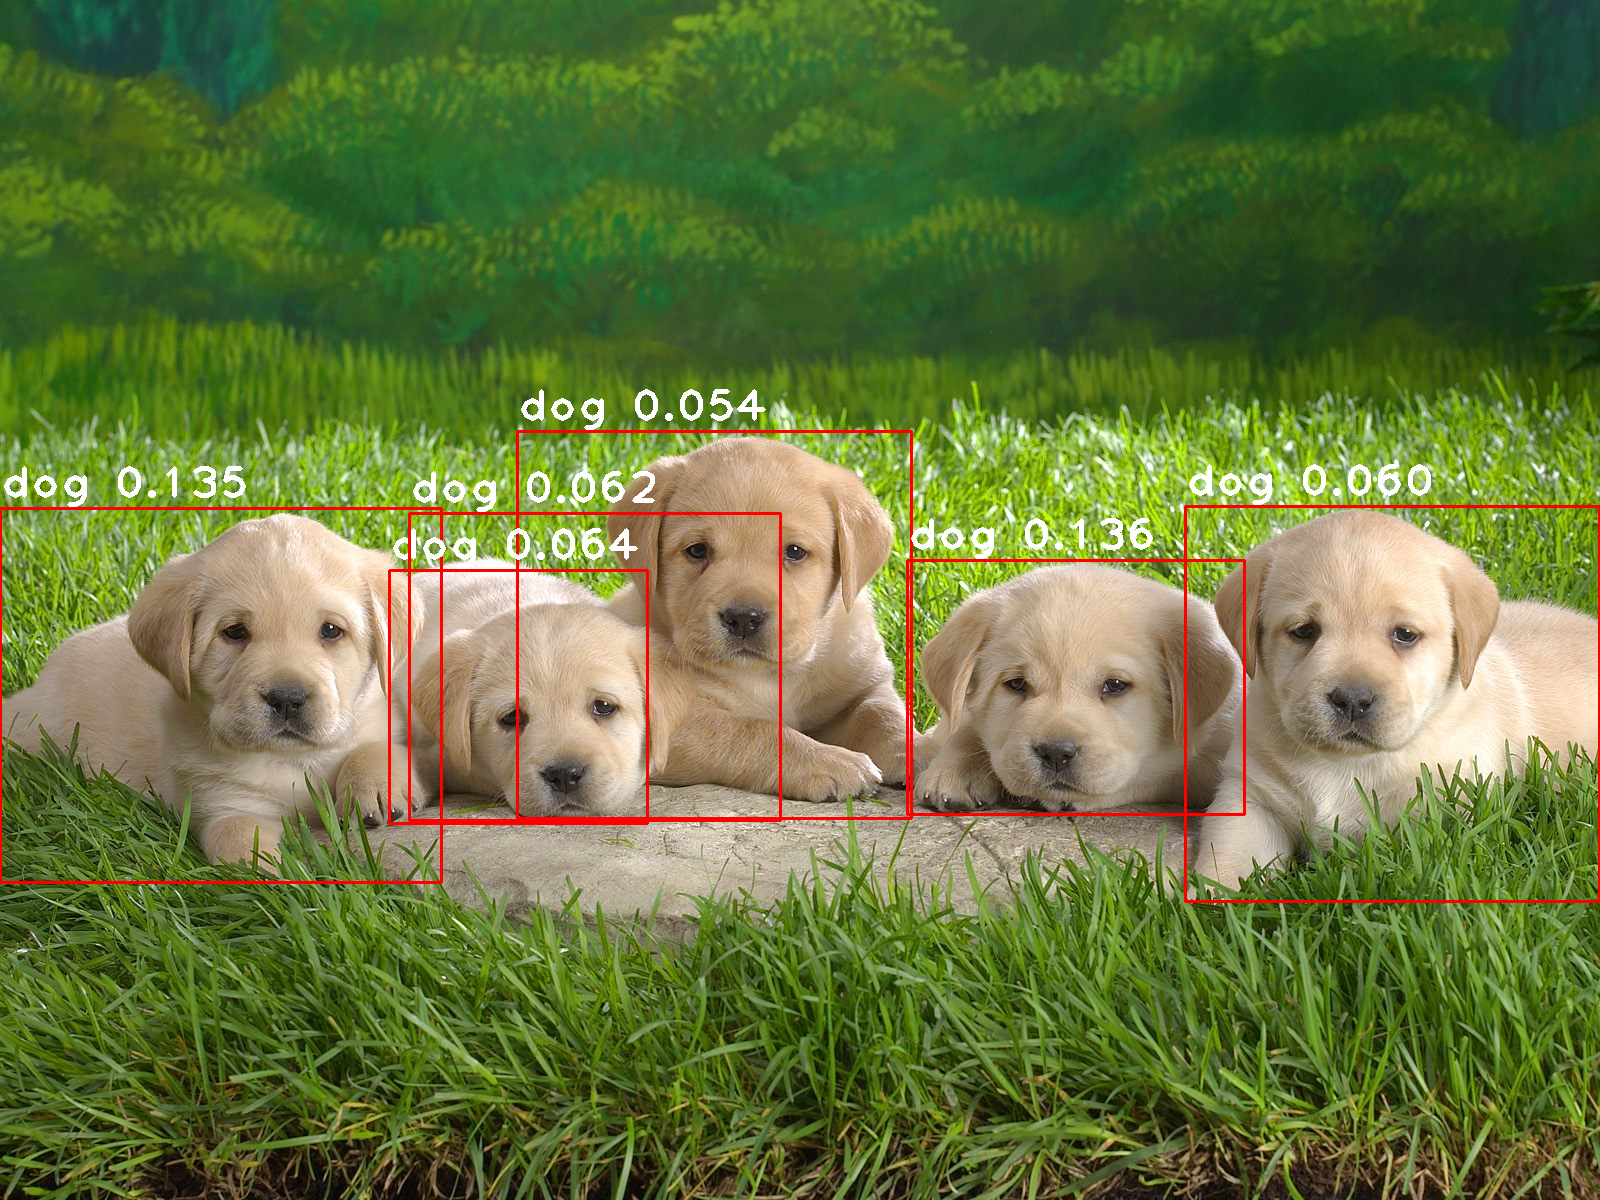

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

img, labels_lst, bbox_lst = detect_image("./data", "./retinanet_pretrained.pt", "./class_mapping.csv")
Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [78]:
def retinanet_reshape_transform(x):
    target_size = x['pool'].size()[-2 : ]
    activations = []
    for key, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

target_layers = [retinanet.fpn]
cam = EigenCAM(retinanet, target_layers, use_cuda=True, reshape_transform=retinanet_reshape_transform)
grayscale_cam = cam(tensor.to("cuda"))[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

AttributeError: 'list' object has no attribute 'cpu'